# Neutrino direction reconstruction using events from a fixed source


### Jan 18, 2021

## Code

In [11]:
import sys
import csv
# sys.path.insert(0,"/users/PCON0003/cond0068/.local/lib/python3.7/")
sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
# sys.path.append("/users/PCON0003/cond0068/pyrex_sims/fromBen/thesis_work/pyrex-custom/analysis/custom/analysis/")
import ROOT
import math
import numpy as np
from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib as mpl
import matplotlib.pyplot as plt
from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import seaborn as sns
%matplotlib inline
sys.path.insert(1, "/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes")
import deDisperse_util as util
import matplotlib.colors as colors

my_path_plots = os.path.abspath("./plots/")

In [12]:
# mpl.use('agg') 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

current_palette = sns.color_palette('colorblind', 10)
import warnings
warnings.filterwarnings("ignore")


In [13]:
def nuDirReco(polVec,propVec,viewAng):
    propVec = -propVec
    recoDir = np.sin(viewAng)*polVec-np.cos(viewAng)*propVec
    return recoDir

def SphericalToCartesian(phi, theta):
    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)*np.sin(phi)
    z = np.cos(theta)

    return np.array([x,y,z])

def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

def rotatePolVector(launchVecSrc, recVec, PolVecAntenna):
    recVec = -recVec #receiving vector needs to be reflected, otherwise rotation matrix will be off by pi
    newPol = np.dot(PolVecAntenna,rotation_matrix_from_vectors(launchVecSrc,recVec))
    return newPol
chAngle = 55.8 #Cherenkov angle in ice

In [14]:
appended_data = []
import os
for filename in os.listdir("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes/1E18FixedNnu/"):#Loop over desired directory
        if (filename.startswith("1E18")): #extension, .root in this case
            name = os.path.join("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes/1E18FixedNnu/", str(filename))
            data = pd.read_pickle(name)
            appended_data.append(data)
recoNu = pd.concat(appended_data) 
# recoNu = pd.read_pickle("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes/debug/pol_quant_noiseless.pkl")
recoNu = recoNu.loc[abs(recoNu.maxV)>1]
recoNu = recoNu.loc[abs(recoNu.maxV)<1450]
recoNu = recoNu.loc[abs(recoNu.maxH)>1]
recoNu = recoNu.loc[abs(recoNu.maxH)<1450]
# recoNu = recoNu.loc[recoNu.theta_antenna<=np.pi/2]
# recoNu = recoNu.loc[recoNu.weight>1E-100]
recoNu["SNR_V"] = abs(recoNu.maxV)/recoNu.rmsV
recoNu["SNR_H"] = abs(recoNu.maxH)/recoNu.rmsH
# recoNu = recoNu.loc[abs(recoNu.SNR_H-5)<1]
recoNu = recoNu.loc[recoNu.SNR_H>=5]
recoNu = recoNu.loc[recoNu.SNR_V>=5]

array2 = []
R_True = []
R_Reco = []
propVec = []
dot = []
nnu_Reco = []
rec_angle = []
for i in recoNu.itertuples(): 
    thetaHat = np.array([np.cos(i.theta_antenna)*np.cos(i.phi_antenna), np.cos(i.theta_antenna)*np.sin(i.phi_antenna), -np.sin(i.phi_antenna)])
    phiHat = np.array([-np.sin(i.phi_antenna), np.cos(i.phi_antenna),0])
    if(i.powerH==0 or i.powerV==0):
        R_Reco.append(np.nan)
        R_True.append(np.nan)
        array2.append(np.nan)
        dot.append(np.nan)
        nnu_Reco.append(np.nan)
        rec_angle.append(np.nan)
        continue
    R_Reco.append(np.sqrt(i.powerH/i.powerV))
#     R_Reco.append(abs(i.peak_H/i.peak_V))
    R = np.dot(i.PolTrue,phiHat)/(np.dot(i.PolTrue,thetaHat))
    R_True.append(R)
    polRecoAntenna = util.PolVectorRecoPower_debug(i.powerV,i.powerH, i.theta_antenna, i.phi_antenna,np.sign(R))
    array2.append(polRecoAntenna)
    phi_launch = np.arctan2(i.dirProp[1],i.dirProp[0])
    theta_launch = np.pi-i.launch_ang
    launchVec = -1*SphericalToCartesian(phi_launch,theta_launch)
    polVecSrc = rotatePolVector(launchVec,i.dirProp,polRecoAntenna)
    nnu_Reco.append(nuDirReco(-polVecSrc,launchVec,i.view_ang))

    rec_angle.append(np.arccos(i.dirProp[2]))
recoNu["PolReco2"] = array2
recoNu["nnu_Reco"] = nnu_Reco
recoNu["rec_angle"] = rec_angle

recoNu["R_True"] = R_True
recoNu["R_Reco"] = R_Reco
recoNu = recoNu.dropna()

Px_true = np.array([element[0] for element in recoNu.PolTrue])
Py_true = np.array([element[1] for element in recoNu.PolTrue])
Pz_true = np.array([element[2] for element in recoNu.PolTrue])

Px_reco = np.array([element[0] for element in recoNu.PolReco2])
Py_reco = np.array([element[1] for element in recoNu.PolReco2])
Pz_reco = np.array([element[2] for element in recoNu.PolReco2])


nnuX_true = np.array([element[0] for element in recoNu.nnu])
nnuY_true = np.array([element[1] for element in recoNu.nnu])
nnuZ_true = np.array([element[2] for element in recoNu.nnu])

nnuX_reco = np.array([element[0] for element in recoNu.nnu_Reco])
nnuY_reco = np.array([element[1] for element in recoNu.nnu_Reco])
nnuZ_reco = np.array([element[2] for element in recoNu.nnu_Reco])

omega_true = np.degrees(np.arccos((Pz_true)))
omega_reco = np.degrees(np.arccos((Pz_reco)))
psi_true = np.degrees(np.arctan((Py_true),(Px_true)))
psi_reco = np.degrees(np.arctan((Py_reco),(Px_reco)))

thetaNnu_true = np.degrees(np.arccos((nnuZ_true)))
thetaNnu_reco = np.degrees(np.arccos((nnuZ_reco)))
phiNnu_true = np.degrees(np.arctan((nnuY_true)/(nnuX_true)))
phiNnu_reco = np.degrees(np.arctan((nnuY_reco)/(nnuX_reco)))

recoNu["omega_reco"] = omega_reco
recoNu["psi_reco"] = psi_reco
recoNu["omega_true"] = omega_true
recoNu["psi_true"] = psi_true

recoNu["thetaNnu_reco"] = thetaNnu_reco
recoNu["phiNnu_reco"] = phiNnu_reco
recoNu["thetaNnu_true"] = thetaNnu_true
recoNu["phiNnu_true"] = phiNnu_true
recoNu["delta"] = thetaNnu_reco-thetaNnu_true
recoNu["deltaPhi"] = phiNnu_reco-phiNnu_true

recoNu = recoNu.dropna()
print(len(recoNu))
# recoNu = recoNu.loc[recoNu.phiNnu_reco<40]

967


Text(0,0.5,'$\\theta$')

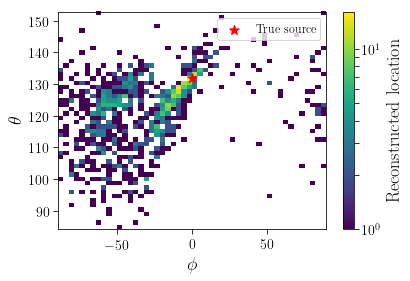

In [15]:
trueNnu_theta = recoNu.thetaNnu_true.unique()[0]
trueNnu_phi = recoNu.phiNnu_true.unique()[0]
plt.hist2d(recoNu.phiNnu_reco,recoNu.thetaNnu_reco, bins=50,norm=colors.LogNorm(),label ="Reco source", weights=recoNu.weight);
plt.colorbar(label = "Reconstructed location")
plt.scatter(trueNnu_phi,trueNnu_theta,s=100,c="red",marker="*",label ="True source")

plt.legend()
# plt.xlim(-20,20)
# plt.ylim(131,135)
plt.xlabel("$\phi$")
plt.ylabel("$\\theta$")

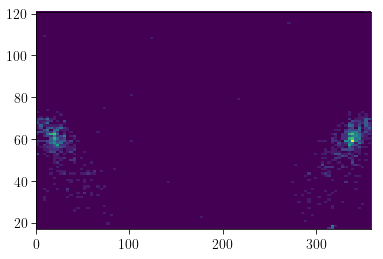

In [16]:
plt.hist2d(np.degrees(recoNu.phi_reco),90-np.degrees(recoNu.theta_reco)+chAngle, bins=100, weights=recoNu.weight);
plt.scatter(trueNnu_phi,trueNnu_theta,s=100,c="red",marker="*",label ="True source")

# plt.ylim(50,125)

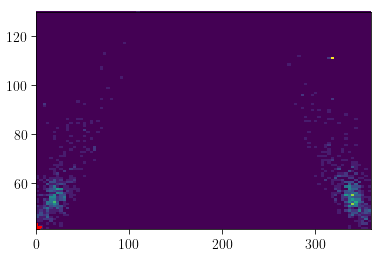

In [17]:
plt.hist2d(np.degrees(recoNu.phi_antenna),90-np.degrees(recoNu.theta_antenna)+chAngle, bins=100, weights=recoNu.weight);
plt.scatter(recoNu.phiNnu_true[0],recoNu.thetaNnu_true[0]-90,s=100,c="red",marker="*",label ="True source")
# 
# plt.ylim(40,70)

# Convert to Galactic coordinates with AstroPy

In [18]:
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import astropy.coordinates as coord
from astropy.io import ascii

In [19]:
# trueNnu_theta = recoNu.thetaNnu_true.unique()[0]
# trueNnu_phi = recoNu.phiNnu_true.unique()[0]


galactic_longitudes = np.arange(start=0, stop=360, step=0.1)
galactic_latitudes = [0] * len(galactic_longitudes)
icrs = SkyCoord(galactic_longitudes, galactic_latitudes, unit="deg", frame="galactic").icrs
gal_ra = icrs.ra
gal_ra = gal_ra.wrap_at(180*u.degree)
gal_dec = icrs.dec

gal_center_long = 180.
gal_center_lat = 0.
cena_long = 309.51589568
cena_lat = 19.41727350
icrs2 = SkyCoord(gal_center_long, gal_center_lat, unit="deg", frame="galactic").icrs
gal_center_ra = icrs2.ra
gal_center_ra = gal_center_ra.wrap_at(180*u.degree)
gal_center_dec = icrs2.dec

icrs3 = SkyCoord(cena_long, cena_lat, unit="deg", frame="galactic").icrs
#cena_ra = icrs3.ra
#cena_ra = cena_ra.wrap_at(180*u.degree)
#cena_dec = icrs3.dec
ra_gc=np.degrees(recoNu.phi_antenna)*u.degree
dec_gc=(np.degrees(recoNu.theta_antenna)-chAngle)* u.degree
ra_cena = 201.3625*u.degree
dec_cena = -43.0192*u.degree

true_ra = (trueNnu_phi)*u.degree
true_dec = (trueNnu_theta-90)*u.degree
c2 = SkyCoord(ra=true_ra, dec=true_dec, frame='icrs')
true_ra = c2.ra.wrap_at(180 * u.deg).radian
true_dec = c2.dec.radian

reco_ra = (recoNu.phiNnu_reco)*u.degree
reco_dec = (recoNu.thetaNnu_reco-90)*u.degree
c3 = SkyCoord(ra=reco_ra, dec=reco_dec, frame='icrs')
reco_ra = c3.ra.wrap_at(180 * u.deg).radian
reco_dec = c3.dec.radian

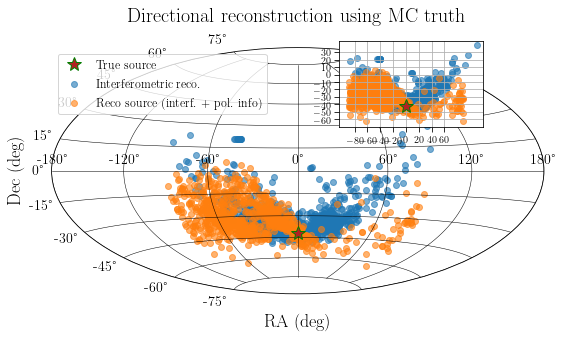

In [20]:
c = SkyCoord(ra=ra_gc, dec=dec_gc, frame='icrs')
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111, projection="hammer")
ra_rad = c.ra.wrap_at(180 * u.deg).radian
dec_rad = c.dec.radian
ax.grid(color='k', linestyle='solid', linewidth=0.5)
r = 90

plt.plot(true_ra, -true_dec, '*',color='firebrick',markersize=15,mec='green',label='True source')
plt.scatter(ra_rad, -dec_rad, alpha=0.6,label='Interferometric reco.')
plt.scatter(reco_ra, -reco_dec, alpha=0.6,label='Reco source (interf. + pol. info)')


# plt.scatter(recoNu.phiNnu_true[0]*u.degree,(recoNu.thetaNnu_true[0])*u.degree,c="red",marker="*",label ="True source")

# ax.plot(cena_ra, cena_dec,'^',markersize=9,color='m',label='Centaurus A')
# plt.plot(gal_ra.radian[0:2970], -gal_dec.radian[0:2970],color='firebrick',linewidth=2,label='Galactic Plane',zorder=1)
# plt.plot(gal_ra.radian[2980:], -gal_dec.radian[2980:],color='firebrick',linewidth=2,zorder=2)

 

# legend.get_frame().set_facecolor('#ffe4c4')
ax.legend(loc = 'upper left')
ax.set_ylabel('Dec (deg)') #give it a title
ax.set_xlabel('RA (deg)',labelpad=20) #give it a title
ax.axes.get_xaxis().set_ticks([-np.pi/3, -2*np.pi/3, -np.pi,0,np.pi/3, 2*np.pi/3, np.pi])
plt.title("Directional reconstruction using MC truth",y=1.08)

ax_new = fig.add_axes([0.6, 0.6, 0.25, 0.2]) # the position of zoom-out plot compare to the ratio of zoom-in plot 

plt.plot(np.degrees(true_ra), np.degrees(-true_dec), '*',color='firebrick',markersize=15,mec='green',label='True source')
plt.scatter(np.degrees(ra_rad), np.degrees(-dec_rad), alpha=0.6,label='Interferometric reco.')
plt.scatter(np.degrees(reco_ra), np.degrees(-reco_dec), alpha=0.6,label='Reco source (interf. + pol. info)')
ax_new.set_xticks(np.arange(-80,80,20))
ax_new.set_yticks(np.arange(-60,40,10))
ax_new.grid()

for tick in ax_new.xaxis.get_major_ticks():
                tick.label.set_fontsize(10) 
for tick in ax_new.yaxis.get_major_ticks():
                tick.label.set_fontsize(10) 
plt.tight_layout()
# ax.show()
# plt.savefig(my_path_plots+'/NuDirReco/SkyMap_fixedSourceKotera.png', dpi=250)

In [21]:
from scipy.stats import gaussian_kde
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm

x=recoNu.phiNnu_reco
y=recoNu.thetaNnu_reco
# y = theta
xy = np.vstack([x,y])
kernel = gaussian_kde(xy, bw_method='silverman', weights=recoNu.weight)

xmin = min(x)
xmax = max(x)
ymin = min(y)
ymax = max(y)

# xmin = -180
# xmax = 180
# ymin = 0
# ymax = 180

In [22]:
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kernel(positions).T, X.shape)

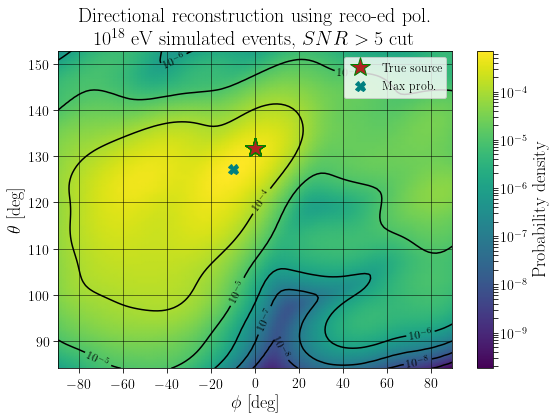

In [23]:
fig = plt.figure(figsize=(8,6))

# ax = fig.add_subplot(111, projection="hammer")
# kernel.evaluate
maxVal = np.argmax(Z)
positions.T[maxVal]
levels = [1e-1]

# contours = plt.contour(X, Y, Z,levels,locator=plt.LogLocator(),colors="black")
contours = plt.contour(X, Y, Z,locator=plt.LogLocator(),colors="black")
# cmap = plt.contourf(X, Y, Z,200)
fmt = ticker.LogFormatterMathtext()
fmt.create_dummy_axis()
plt.clabel(contours, contours.levels,color="black", fmt=fmt, inline=True)
cmap=plt.pcolormesh(X, Y, Z,shading='gouraud', norm=colors.LogNorm())
# plt.scatter(recoNu.phiNnu_reco,recoNu.thetaNnu_reco, color = "white", label="Scatter")
plt.plot(recoNu.phiNnu_true[0],recoNu.thetaNnu_true[0],"*",color='firebrick',mec='green',markersize = 20,label ="True source")
plt.plot(positions.T[maxVal][0],positions.T[maxVal][1],"X",color='teal',mec='teal',markersize = 10,label ="Max prob.")
# cmap = plt.get_cmap('PiYG')
plt.colorbar(cmap,label='Probability density',norm=LogNorm())
plt.title("Directional reconstruction using reco-ed pol.\n $10^{18}$ eV simulated events, $SNR>5$ cut")
plt.xlabel("$\phi$ [deg]")
plt.ylabel("$\\theta$ [deg]")
plt.grid(color='k', linestyle='solid', linewidth=0.5)
plt.legend()
plt.tight_layout()
# plt.savefig(my_path_plots+"/NuDirReco/KDE_Fixed_recoNnu_1E18.png", dpi=200)

### More plots

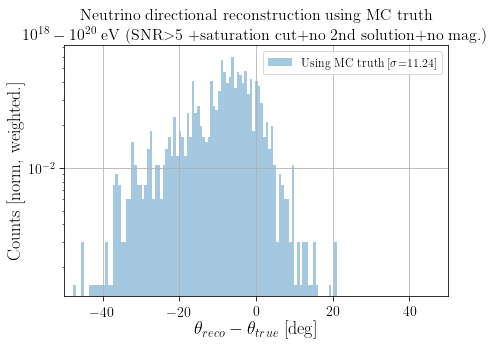

In [27]:
delta = recoNu["delta"]
plt.figure(figsize=(7,5))
delta_mean= np.ma.average(delta,weights=recoNu.weight)
variance = np.dot(recoNu.weight, (delta - delta_mean) ** 2) / recoNu.weight.sum()
delta_std = np.sqrt(variance)

sns.distplot(delta, bins=100,hist_kws={'weights': recoNu.weight},norm_hist=True,kde=False,label = "Using MC truth [$\sigma$=%0.2f]"%(delta_std));

# delta_std = recoNu_noise.deltaTheta.std()
# delta_mean = recoNu_noise.deltaTheta.mean()
# plt.hist(recoNu_noise.deltaTheta, bins=500, density=True, alpha=0.5, color="C1",label = "W/noise [$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean, delta_std));

plt.xlabel("$\\theta_{reco}-\\theta_{true}$ [deg]")
# plt.xlabel("$\\theta$")
plt.ylabel('Counts [norm, weighted.]')
# plt.title("Polarization reconstruction vs. MC truth \n $10^{18}-10^{21}$ eV events (no cuts)")
plt.title("Neutrino directional reconstruction using MC truth \n $10^{18}-10^{20}$ eV (SNR$>$5 +saturation cut+no 2nd solution+no mag.)", fontsize=16)
plt.xlim(-50,50)
plt.yscale('log')
plt.grid()
plt.legend()
plt.tight_layout()
# plt.savefig(my_path_plots+'/Dumpster/recoVsTrue_AraSim_noCuts.pdf')
# plt.savefig(my_path_plots+'/Dumpster/recoVsTrue_noNoiseOmega.png', dpi=250)


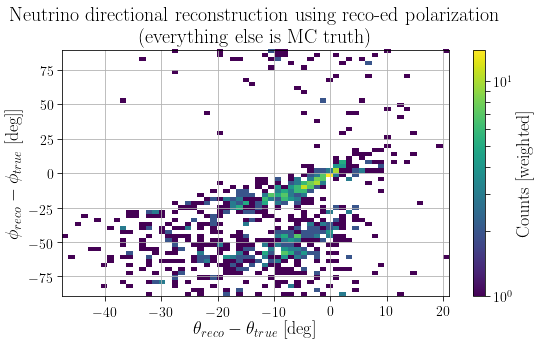

In [28]:
plt.figure(figsize=(8,5))

plt.hist2d(recoNu["delta"],recoNu["deltaPhi"], bins = 60,norm=colors.LogNorm(), weights=recoNu.weight);
plt.colorbar(label="Counts [weighted]")
plt.xlabel("$\\theta_{reco}-\\theta_{true}$ [deg]")
plt.ylabel("$\phi_{reco}-\phi_{true}$ [deg]]")
plt.title("Neutrino directional reconstruction using reco-ed polarization\n (everything else is MC truth)")
# plt.xlim(0,100)
# plt.ylim(0,100)
# plt.xticks(np.arange(0,100,10))
# plt.yticks(np.arange(-360,360,60))
plt.grid()
# plt.plot(x,y,"--", c = "red", alpha = 0.3, label = "$y=x$")
# plt.legend()
plt.tight_layout()
# plt.savefig(my_path_plots+'/NuDirReco/deltaPhiDeltaTheta.png', dpi=250)

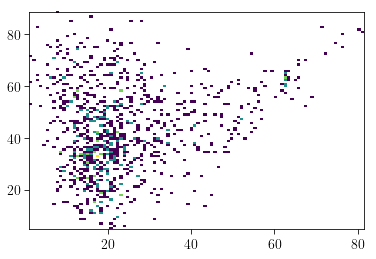

In [30]:
plt.hist2d(recoNu.omega_true,recoNu.omega_reco, bins=100, weights=recoNu.weight,norm=colors.LogNorm());